Setup and Imports

In [11]:


# Import necessary libraries
import torch
import torch.nn as nn
import unidecode
import string
import random
import time
import matplotlib.pyplot as plt

# Check device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


Dataset Preparation

In [ ]:
# Download and load the dataset ("Alice in Wonderland")
!wget -O alice.txt https://www.gutenberg.org/files/11/11-0.txt

# Define characters and load text data
all_characters = string.printable
n_characters = len(all_characters)

file_path = 'alice.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print("Total dataset length:", file_len)

# Split the data into train and test sets (90% train, 10% test)
split_idx = int(0.9 * file_len)
train_text = file[:split_idx]
test_text = file[split_idx:]

print("Train text length:", len(train_text))
print("Test text length:", len(test_text))


--2024-11-09 16:47:15--  https://www.gutenberg.org/files/11/11-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154571 (151K) [text/plain]
Saving to: ‘alice.txt’

alice.txt           100%[===================>] 150.95K  --.-KB/s    in 0.03s   

2024-11-09 16:47:15 (4.29 MB/s) - ‘alice.txt’ saved [154571/154571]

Total dataset length: 144957
Train text length: 130461
Test text length: 14496


Helper Functions

In [13]:
# Define chunk length
chunk_len = 200

def random_chunk(text):
    start_idx = random.randint(0, len(text) - chunk_len - 2)
    end_idx = start_idx + chunk_len + 1
    return text[start_idx:end_idx]



# Function to convert a string to a tensor of character indices
def char_tensor(text):
    tensor = torch.zeros(len(text)).long()
    for c in range(len(text)):
        tensor[c] = all_characters.index(text[c])
    return tensor

# Function to load a random batch of data
def load_random_batch(text, chunk_len, batch_size, device):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target_data = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        chunk = random_chunk(text)
        input_data[i] = char_tensor(chunk[:-1])
        target_data[i] = char_tensor(chunk[1:])
    return input_data, target_data


GRU Model Definition

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.encoder(input)  # Shape: (batch_size, seq_len, hidden_size)
        output, hidden = self.gru(embedded, hidden)  # Shape: (batch_size, seq_len, hidden_size)
        output = self.decoder(output)  # Shape: (batch_size, seq_len, n_characters)
        return output, hidden

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)


Training and Evaluation Functions

In [15]:
def train(model, input_data, target_data, optimizer, criterion):
    model.train()
    hidden = model.init_hidden(input_data.size(0), device)

    optimizer.zero_grad()
    output, hidden = model(input_data, hidden)

    # Reshape output and target data for loss calculation
    output = output.reshape(-1, n_characters)
    target_data = target_data.reshape(-1)

    # Compute loss
    loss = criterion(output, target_data)

    # Backpropagation and optimization
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
    optimizer.step()

    return loss.item()


def eval_test(model, input_data, target_data):
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(input_data.size(0), device)
        output, hidden = model(input_data, hidden)

        # Reshape output and target data for loss calculation
        output = output.reshape(-1, n_characters)
        target_data = target_data.reshape(-1)

        # Compute loss
        loss = criterion(output, target_data)

    return loss.item()



Training Loop

In [25]:
# Hyperparameters
hidden_size = 256
n_layers = 2
learning_rate = 0.003
batch_size = 100
n_epochs = 2000

# Initialize the model, optimizer, and loss function
model = GRUModel(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



# Lists to store losses for plotting
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0
print_every = 100
plot_every = 100

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    # Load random batch for training
    input_data, target_data = load_random_batch(train_text, chunk_len, batch_size, device)
    loss = train(model, input_data, target_data, optimizer, criterion)
    loss_avg += loss

    # Load random batch for testing
    test_input, test_target = load_random_batch(test_text, chunk_len, batch_size, device)
    test_loss = eval_test(model, test_input, test_target)
    test_loss_avg += test_loss

    # Print progress every print_every epochs
    if epoch % print_every == 0:
        print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

    # Record losses for plotting
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 2000 epochs...
Epoch 100 | Train Loss: 1.5167 | Test Loss: 1.5697
Epoch 200 | Train Loss: 1.1766 | Test Loss: 1.3971
Epoch 300 | Train Loss: 1.0105 | Test Loss: 1.4144
Epoch 400 | Train Loss: 0.8856 | Test Loss: 1.4017
Epoch 500 | Train Loss: 0.7745 | Test Loss: 1.5247
Epoch 600 | Train Loss: 0.7142 | Test Loss: 1.5694
Epoch 700 | Train Loss: 0.6755 | Test Loss: 1.7159
Epoch 800 | Train Loss: 0.6159 | Test Loss: 1.7457
Epoch 900 | Train Loss: 0.5964 | Test Loss: 1.7991
Epoch 1000 | Train Loss: 0.5727 | Test Loss: 1.7676
Epoch 1100 | Train Loss: 0.5546 | Test Loss: 1.8859
Epoch 1200 | Train Loss: 0.5447 | Test Loss: 1.8920
Epoch 1300 | Train Loss: 0.5328 | Test Loss: 1.9508
Epoch 1400 | Train Loss: 0.5276 | Test Loss: 1.9877
Epoch 1500 | Train Loss: 0.5099 | Test Loss: 1.9561
Epoch 1600 | Train Loss: 0.4849 | Test Loss: 2.0360
Epoch 1700 | Train Loss: 0.4800 | Test Loss: 2.0732
Epoch 1800 | Train Loss: 0.4767 | Test Loss: 2.0258
Epoch 1900 | Train Loss: 0.4740 | Test Loss: 

 Plotting the Losses

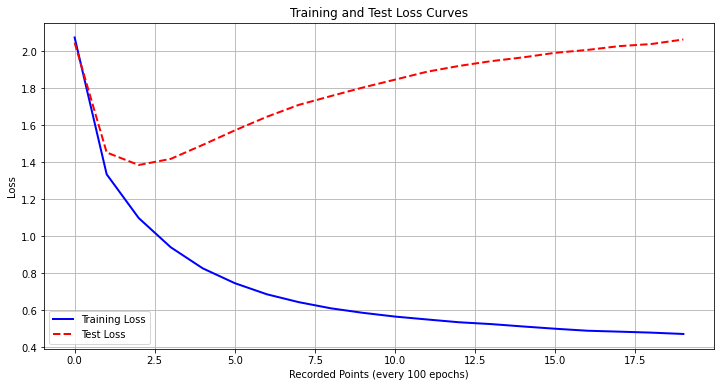

In [27]:
import matplotlib.pyplot as plt

if len(all_losses) > 0 and len(test_losses) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(all_losses, label="Training Loss", color='blue', linewidth=2)
    plt.plot(test_losses, label="Test Loss", color='red', linestyle='--', linewidth=2)
    plt.xlabel("Recorded Points (every 100 epochs)")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss values recorded. Please check your training loop.")


Text Generation

In [30]:
def generate(model, prime_str='A', predict_len=100, temperature=0.8):
    model.eval()
    hidden = model.init_hidden(1, device)
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p].view(1, 1), hidden)

    inp = prime_input[-1].view(1, 1)
    for _ in range(predict_len):
        output, hidden = model(inp, hidden)
        output_dist = output.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).view(1, 1).to(device)

    return predicted

# Example generation
print(generate(model, prime_str="Alice", predict_len=200))


Alice had been all the while, however, she
soon made out that she was now about a through the window, and on it, and
the two creatures would not stoop?
Soup of the evening, beautiful Soup!
Soup of the even
